<div>
<img src="attachment:logo_lfe_powsybl.svg" width="500"/>
</div>

# Introduction to PyPowSyBl: Network representation, load flow calculation, security analysis and sensitivity analysis

@authors: Alexandre Marié ([Artelys](https://www.artelys.com/)), Coline Piloquet ([Rte](https://www.rte-france.com/)), Sophie Frasnedo ([Rte](https://www.rte-france.com/)).

Let's start this notebook by installing and importing pypowsybl!

In [1]:
pip install pypowsybl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://devin-depot.rte-france.com/repository/pypi-all/simple
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to

In [2]:
import pypowsybl as pp

## 1 - Network presentation

The network used for this tutorial consists of 6 voltage levels, all of which are connected by two parallel lines with the same electrotechnical characteristics (same resistance and same reactance for each line), as well as two HVDC lines and a Phase-Shifting Transformer (PST). It also has 4 generating units and 3 loads.

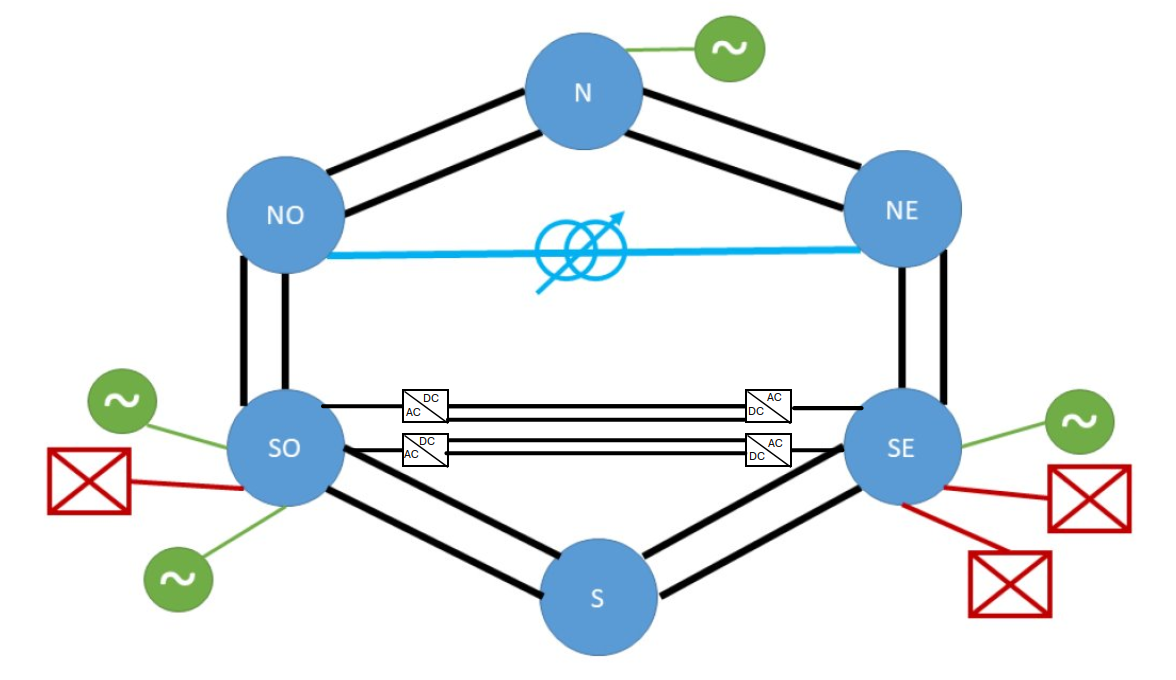

The network is available in the pyPowSyBl library and can be loaded with the function create_metrix_tutorial_six_buses_network.

In [3]:
n6 = pp.network.create_metrix_tutorial_six_buses_network()

In order to display the network, we can draw the network area diagram. This type of diagram displays the voltage levels and how they are connected to each other.

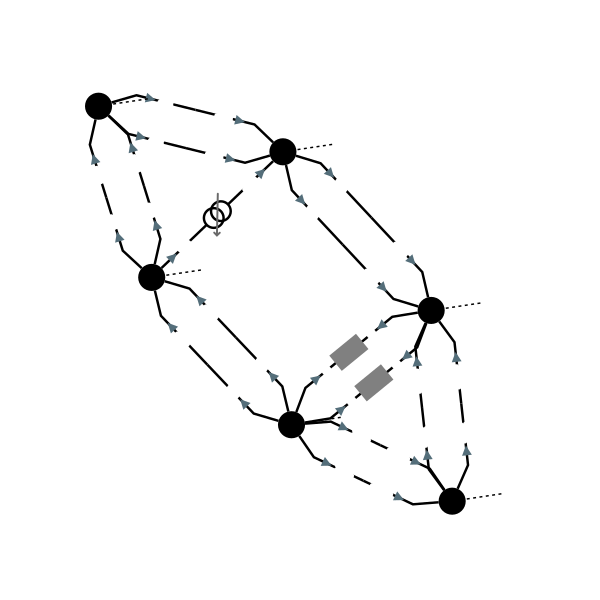

In [4]:
n6.get_network_area_diagram()

If we wish to get a more detailed view of the network, featuring each component (busbars, switches, generators, loads etc.), we can display a single-line diagram.
Here, we chose to display the single-line diagram of the 'SE' substation.

In [5]:
n6.get_single_line_diagram('SE')

We can display node info:

In [6]:
n6.get_substations()

,name,TSO,geo_tags,country
id,,,,
NO,,,,
S,,,,
SO,,,,
SE,,,,
N,,,,


Generator info:

In [7]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,100.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,NaN,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,NaN,NaN,N_poste,N_poste_0,True


Load info:

In [8]:
n6.get_loads()

,name,type,p0,q0,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,
SO_L,,UNDEFINED,480.0,4.8,480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_L1,,UNDEFINED,480.0,4.8,480.0,NaN,NaN,SE_poste,SE_poste_0,True
SE_L2,,UNDEFINED,0.0,4.8,0.0,NaN,NaN,SE_poste,SE_poste_0,True


## 2- Production and demand trends

Let's consider that production and demand evolve over 3 hourly time steps:

| Ts | SE_L1 | SO_G1 | SO_G2 |
| --- | --- | --- | --- |
| T01 | 960 | 0 | 960 |
| T02 | 960 | 960 | 0 |
| T03 | 960 | 960 | 0 |


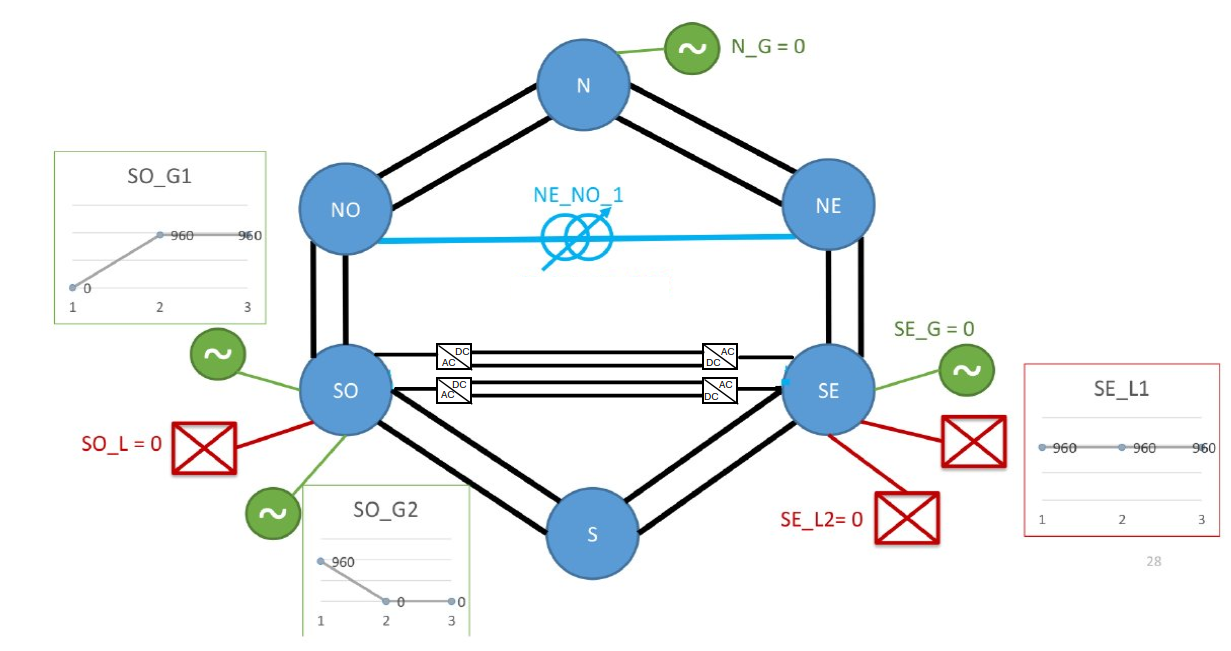

Let's take a look at the first time step and change the production accordingly:

In [9]:
n6.update_generators(id='SO_G1', target_p=0)
n6.update_generators(id='SO_G2', target_p=960)
n6.update_generators(id='SE_G', target_p=0)

In [10]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,0.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,960.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,NaN,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,NaN,NaN,N_poste,N_poste_0,True


Then, we modify the active power loads and display the data:

In [11]:
n6.update_loads(id='SO_L', p0=0)
n6.update_loads(id='SE_L1', p0=960)
n6.update_loads(id='SE_L2', p0=0)

In [12]:
n6.get_loads()

,name,type,p0,q0,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,
SO_L,,UNDEFINED,0.0,4.8,480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_L1,,UNDEFINED,960.0,4.8,480.0,NaN,NaN,SE_poste,SE_poste_0,True
SE_L2,,UNDEFINED,0.0,4.8,0.0,NaN,NaN,SE_poste,SE_poste_0,True


## 3 - Load flow computation

Let's run a load flow in order to analyze the base case.

The base case (also called the N case) represents the nominal state of the network (no failures).

In [13]:
results = pp.loadflow.run_dc(n6)

In [14]:
results

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='NE_poste_0', slack_bus_results=[SlackBusResult(id='NE_poste_0', active_power_mismatch=-0.0)], distributed_active_power=nan)]

In [15]:
n6.get_lines()

,name,r,x,g1,b1,g2,b2,p1,q1,i1,p2,q2,i2,voltage_level1_id,voltage_level2_id,bus1_id,bus2_id,connected1,connected2
id,,,,,,,,,,,,,,,,,,,
NO_N_1,,1.0,1.0,0.0,0.0,0.0,0.0,101.040745,NaN,NaN,-101.040745,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
NO_N_2,,2.0,1.0,0.0,0.0,0.0,0.0,101.040745,NaN,NaN,-101.040745,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
S_SE_1,,3.0,1.0,0.0,0.0,0.0,0.0,290.520372,NaN,NaN,-290.520372,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SE_2,,4.0,1.0,0.0,0.0,0.0,0.0,290.520372,NaN,NaN,-290.520372,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SO_1,,5.0,1.0,0.0,0.0,0.0,0.0,-290.520372,NaN,NaN,290.520372,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
S_SO_2,,6.0,1.0,0.0,0.0,0.0,0.0,-290.520372,NaN,NaN,290.520372,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
SO_NO_1,,7.0,1.0,0.0,0.0,0.0,0.0,189.479628,NaN,NaN,-189.479628,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
SO_NO_2,,8.0,1.0,0.0,0.0,0.0,0.0,189.479628,NaN,NaN,-189.479628,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
NE_N_1,,9.0,1.0,0.0,0.0,0.0,0.0,-101.040745,NaN,NaN,101.040745,NaN,NaN,NE_poste,N_poste,NE_poste_0,N_poste_0,True,True


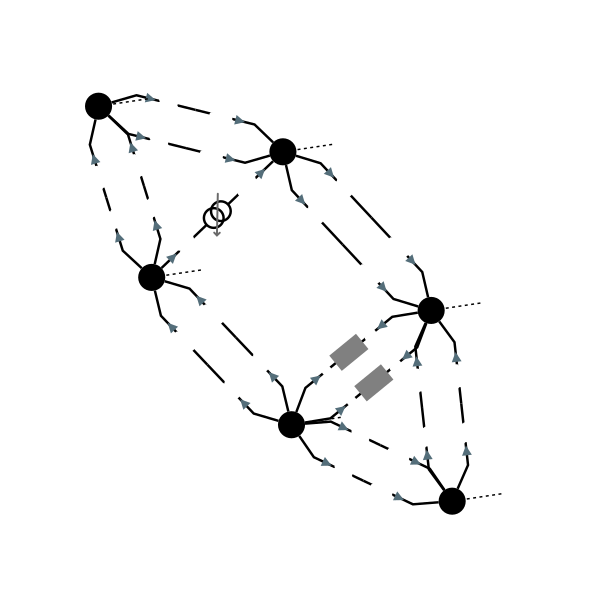

In [16]:
n6.get_network_area_diagram()

In the base case, the generating units and the loads are both located south. The flow takes the path of least resistance so it goes mostly through the SO -> S -> SE lines. There is also flow on the PST, and to the north.

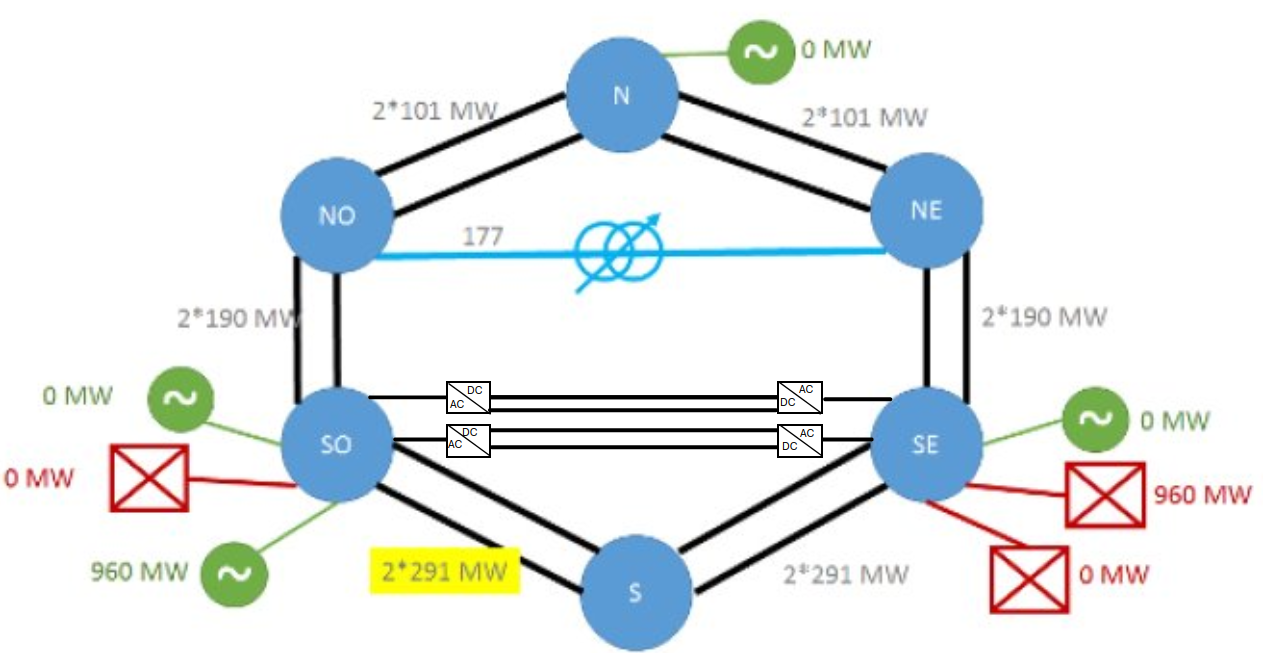

Now, let's assume we're faced with the loss of the `S_SO_1` line. 

This situation is called a N-1 case.

In [17]:
n6.disconnect(id='S_SO_1')

True

In [18]:
results = pp.loadflow.run_dc(n6)

In [19]:
results

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='NE_poste_0', slack_bus_results=[SlackBusResult(id='NE_poste_0', active_power_mismatch=-0.0)], distributed_active_power=nan)]

In [20]:
n6.get_lines()

,name,r,x,g1,b1,g2,b2,p1,q1,i1,p2,q2,i2,voltage_level1_id,voltage_level2_id,bus1_id,bus2_id,connected1,connected2
id,,,,,,,,,,,,,,,,,,,
NO_N_1,,1.0,1.0,0.0,0.0,0.0,0.0,125.250843,NaN,NaN,-125.250843,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
NO_N_2,,2.0,1.0,0.0,0.0,0.0,0.0,125.250843,NaN,NaN,-125.250843,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
S_SE_1,,3.0,1.0,0.0,0.0,0.0,0.0,242.100337,NaN,NaN,-242.100337,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SE_2,,4.0,1.0,0.0,0.0,0.0,0.0,242.100337,NaN,NaN,-242.100337,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SO_1,,5.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,S_poste,SO_poste,,,False,False
S_SO_2,,6.0,1.0,0.0,0.0,0.0,0.0,-484.200674,NaN,NaN,484.200674,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
SO_NO_1,,7.0,1.0,0.0,0.0,0.0,0.0,237.899663,NaN,NaN,-237.899663,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
SO_NO_2,,8.0,1.0,0.0,0.0,0.0,0.0,237.899663,NaN,NaN,-237.899663,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
NE_N_1,,9.0,1.0,0.0,0.0,0.0,0.0,-125.250843,NaN,NaN,125.250843,NaN,NaN,NE_poste,N_poste,NE_poste_0,N_poste_0,True,True


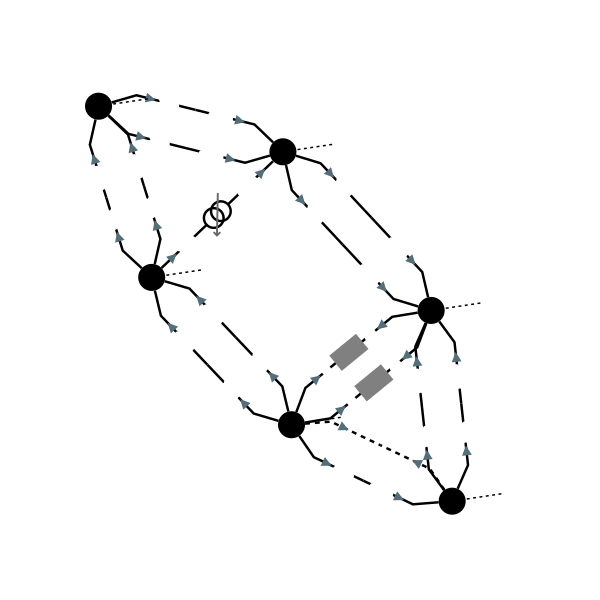

In [21]:
n6.get_network_area_diagram()

The 'S_SO_2' line is overloaded. The network is not secure in this N-1 case.  

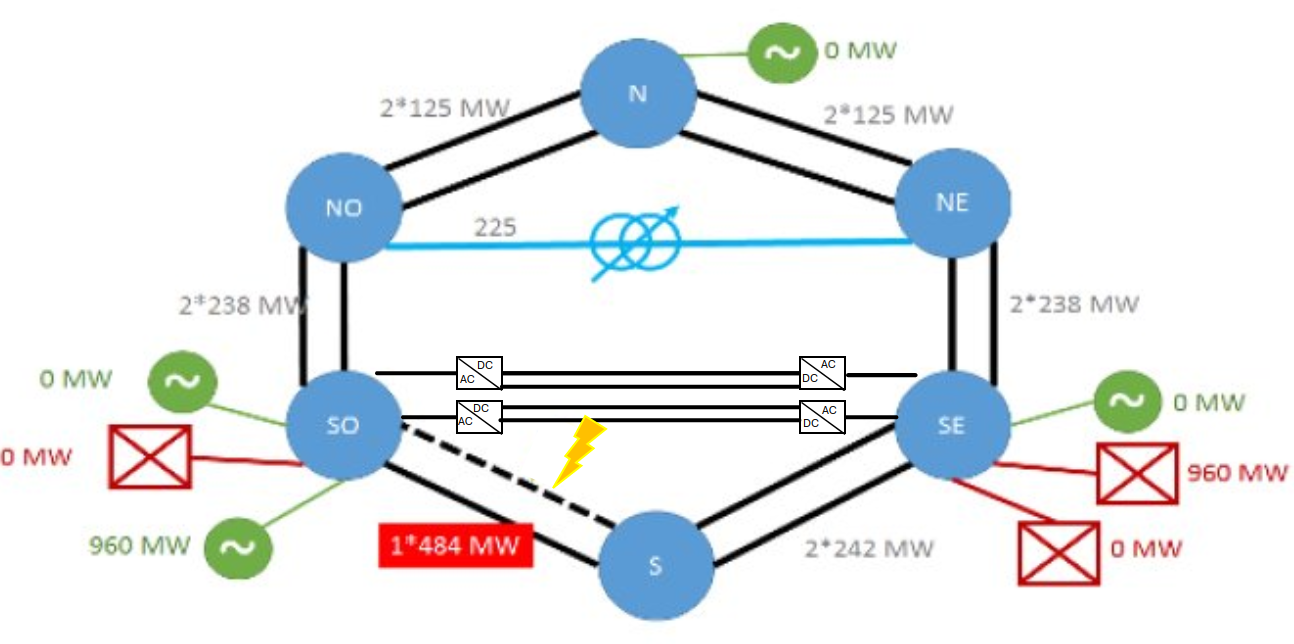

## 4 - Security Analysis

Dispatchers monitor the network in real time. Part of their work is also to anticipate N-1 cases by simulating them and planning actions to be taken if a fault actually occurs.
Manually disconnecting one line, computing a loadflow and checking the limits of every branch of a small network is fastidious. It is nearly impossible on a real network, let alone in real time.
The security analysis deals with that.


Before performing a security analysis, let's reconnect the `S_SO_1` line and consider the second hourly time step. 

In [22]:
n6.connect(id='S_SO_1')

True

In [23]:
n6.update_generators(id='SO_G1', target_p=960)
n6.update_generators(id='SO_G2', target_p=0)
n6.update_generators(id='SE_G', target_p=0)

In [24]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,960.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-0.0,-0.0,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,0.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-960.0,-0.0,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,-0.0,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,-0.0,NaN,N_poste,N_poste_0,True


### 4.1 - DC security analysis

In order to perform a security analysis, you need a network and at least one contingency (i.e. one failure) on that network. 

The violations detected without simulating any failure are collected in the `pre_contingency_result`.
The violations detected while simulating a contingency are collected in the `post_contingency_result`.

In [25]:
security_analysis = pp.security.create_analysis()

In [26]:
security_analysis.add_single_element_contingency('S_SO_1', 'First contingency')

In [27]:
sa_result = security_analysis.run_dc(n6)

In [28]:
sa_result.pre_contingency_result 

PreContingencyResult(, status=CONVERGED, limit_violations=[0])

There is no pre-contingency violations because the base case is secured.

In [29]:
sa_result.post_contingency_results

{'First contingency': PostContingencyResult(contingency_id='First contingency', status=CONVERGED, limit_violations=[2])}

In [30]:
sa_result.limit_violations

subject_name limit_type limit_name       limit  \
contingency_id    subject_id                                                  
First contingency S_SO_2                     CURRENT        10'  600.000000   
                  S_SO_2                     CURRENT  permanent  500.000061   

                              acceptable_duration  limit_reduction  \
contingency_id    subject_id                                         
First contingency S_SO_2                        1              1.0   
                  S_SO_2               2147483647              1.0   

                                   value side  
contingency_id    subject_id                   
First contingency S_SO_2      735.666815  ONE  
                  S_SO_2      735.666815  TWO

In [31]:
n6.get_operational_limits().loc['S_SO_2']

,element_type,side,name,type,value,acceptable_duration
element_id,,,,,,
S_SO_2,LINE,ONE,permanent_limit,CURRENT,5.000001e+02,-1
S_SO_2,LINE,ONE,20',CURRENT,5.500000e+02,1200
S_SO_2,LINE,ONE,10',CURRENT,6.000000e+02,600
S_SO_2,LINE,ONE,1',CURRENT,1.797693e+308,1
S_SO_2,LINE,TWO,permanent_limit,CURRENT,5.000001e+02,-1


The contingency on the `S_SO_1` line leads to an overload on the `S_SO_2` line. 

### 4.2 - Adding monitored Elements

This feature is used to obtain information on various elements of the network after the load flow computations. Information can be obtained on buses, branches and three-windings transformers.

In [32]:
sa = pp.security.create_analysis()

In [33]:
sa.add_single_element_contingencies(['S_SO_1'])

In [34]:
sa.add_monitored_elements(branch_ids=['S_SO_2', 'SO_NO_1', 'SO_NO_2', 'S_SO_1'])

In [35]:
sa_result = sa.run_dc(n6)

In [36]:
sa_result.limit_violations

subject_name limit_type limit_name       limit  \
contingency_id subject_id                                                  
S_SO_1         S_SO_2                     CURRENT        10'  600.000000   
               S_SO_2                     CURRENT  permanent  500.000061   

                           acceptable_duration  limit_reduction       value  \
contingency_id subject_id                                                     
S_SO_1         S_SO_2                        1              1.0  735.666815   
               S_SO_2               2147483647              1.0  735.666815   

                          side  
contingency_id subject_id       
S_SO_1         S_SO_2      ONE  
               S_SO_2      TWO

In [37]:
sa_result.branch_results

p1  q1          i1  \
contingency_id operator_strategy_id branch_id                               
                                    SO_NO_2    189.479628 NaN  287.884510   
                                    SO_NO_1    189.479628 NaN  287.884510   
                                    S_SO_2    -290.520372 NaN  441.400040   
                                    S_SO_1    -290.520372 NaN  441.400040   
S_SO_1                              SO_NO_1    237.899663 NaN  361.451143   
                                    SO_NO_2    237.899663 NaN  361.451143   
                                    S_SO_2    -484.200674 NaN  735.666815   

                                                       p2  q2          i2  \
contingency_id operator_strategy_id branch_id                               
                                    SO_NO_2   -189.479628 NaN  287.884510   
                                    SO_NO_1   -189.479628 NaN  287.884510   
                                    S_SO_2     290.520372 NaN  441.400040   
                                    S_SO_1     290.520372 NaN  441.400040   
S_SO_1                              SO_NO_1   -237.899663 NaN  361.451143   
                                    SO_NO_2   -237.899663 NaN  361.451143   
                                    S_SO_2     484.200674 NaN  735.666815   

                                               flow_transfer  
contingency_id operator_strategy_id branch_id                 
                                    SO_NO_2              NaN  
                                    SO_NO_1              NaN  
                                    S_SO_2               NaN  
                                    S_SO_1               NaN  
S_SO_1                              SO_NO_1        -0.166667  
                                    SO_NO_2        -0.166667  
                                    S_SO_2          0.666667

After the contingency of the line `S_SO_1`, 2/3 of the flow goes to the branch `S_SO_2`, 1/6 to the branch `SO_NO_1` and 1/6 to the branch `SO_NO_2`. 

The power flow limit is exceeded on the branch `S_SO_2`. However, the excess of 84 MW could transit on `SO_NO_1` and `SO_NO_2`. 

There are four possible curative remedial actions to ensure a secure network despite the S_SO_1 contingency:

- Open bus coupler on `SO` (resulting in splitting SO station into two electrical nodes)
- Open bus coupler on `S` (resulting in splitting S station into two electrical nodes)
- Open both couplers
- Open line `S_SO_2`


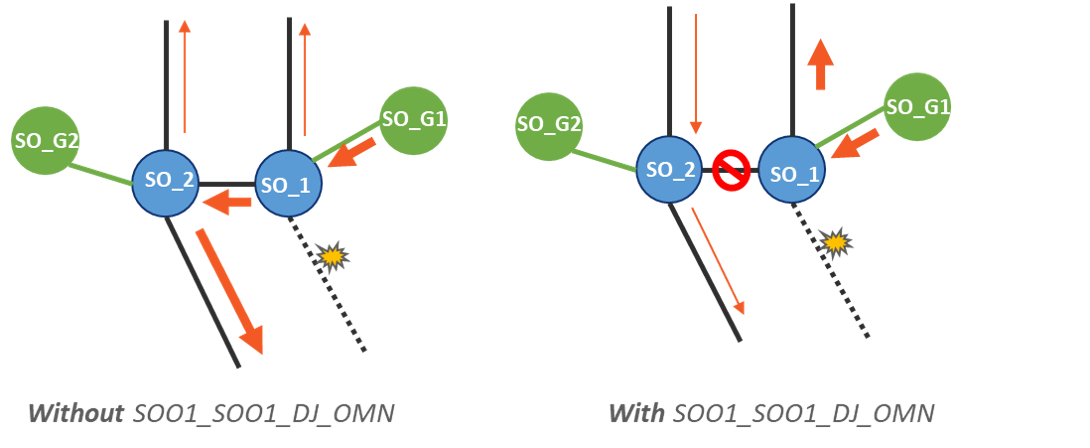

## 5 - Sensitivity Analysis

In case of an increase in electricity demand, the national dispatching center has several production adjustment possibilities.

Two of them are:
- Increasing the production of one or several generators (cf.5.1)
- Asking its neighbors for help (cf. 5.2.)

In both cases, the national dispatching center will compute the impact of that adjustement in some chosen parts of the network. This is done by running a sensitivity analysis.


### 5.1 - Increase the production of a generator

In order to perform a sensitivity analysis, you must first define the “factors” you want to compute. 

What we call a factor is the impact of a small variation of a variable (typically the active power injection of a generator, a load or a phase shifter), on a function (typically the active power flow on a branch). 

To make the definition of those factors easier, `pypowsybl` provides a method to define the variables (injection, phase shifter) through their ids (variables_ids) and the functions through the branch ids (branches_ids). We obtain a matrix of sensitivities as a result:

In [38]:
analysis = pp.sensitivity.create_dc_analysis()
analysis.add_branch_flow_factor_matrix(branches_ids=['S_SO_1', 'S_SO_2'], variables_ids=['SE_G'])
result = analysis.run(n6)

In [39]:
result.get_sensitivity_matrix()

,S_SO_1,S_SO_2
SE_G,0.3,0.3


The result can be interpreted in the following way: an increase of 1 MW on generator SE_G impacts the lines S_SO_1 and S_SO_2 with a 0.3 MW increase of the active power flow from side 1 to side 2.


### 5.2 - Transfer electricity production from one zone to another

This zone-to-zone sensitivity feature is better known as Power Transfer Distribution Factor (PTDF).

It will be the topic of another webinar, hopefully at the end of the year!